### Alunos

* Henrique Capatto
* Mauro Correa Alves

In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import seaborn as sns
import warnings

# semente e remocao de warnings
seed=42
warnings.filterwarnings('ignore')

# Caminho de leitura da base
os.environ["DATASET_PATH"] = os.getcwd().replace('\\','/').replace('training','data/') + 'sample_products.csv'

In [23]:
#lendo dados

# DATASET_PATH = os.getcwd().replace('\\','/').replace('training','data/') + 'sample_products.csv'
data = pd.read_csv(os.environ["DATASET_PATH"])
print(data.shape)
data.head()

(38000, 15)


,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


In [94]:
# categorizando as variáveis
le = preprocessing.LabelEncoder()
le.fit(data['category'])
data['Target'] = le.transform(data['category'])

As categorias da variável estão codificadas da seguinte maneira:

* 0: Bebê
* 1: Bijuterias e Jóias
* 2: Decoração
* 3: Lembrancinhas
* 4: Outros
* 5: Papel e Cia

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['category', 'Target'], axis=1), data['Target'],
                                                    test_size=.2,
                                                    random_state=seed)

print('amostras em treino: %i' % X_train.shape[0],
      'amostras em teste: %i' % X_test.shape[0],
      'número de características: %i' % X_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 30400
amostras em teste: 7600
número de características: 14
número de classes: 6



In [64]:
cols = X_train.dtypes[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')].index

In [65]:
X_train[cols] = X_train[cols].fillna(-99999)

In [66]:
X_test[cols] = X_test[cols].fillna(-99999)

C:\Users\Avell\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Avell\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


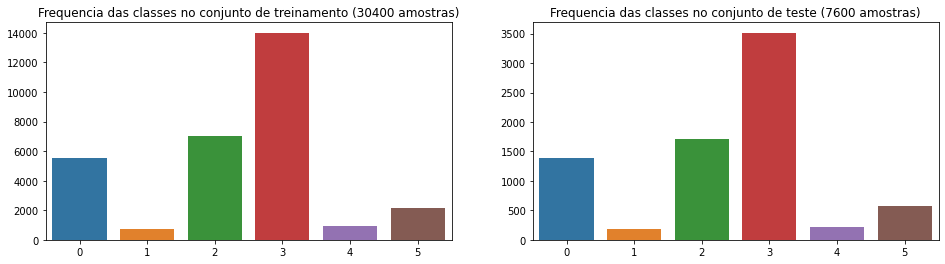

In [45]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(X_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(X_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

Observamos acima que as classes estão bem desbalanceadas entre sim, o que pode comprometer o treinamento do modelo.

Faremos um modelo com peso distintos para cada categoria

### Treinamento

In [84]:
def evaluate(y, p, probabilities, labels=None):
    from sklearn import metrics
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))
    
    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.distplot(probabilities[y.ravel() == i][:, i],
                     hist=False,
                     label=labels[i])

In [87]:
parameters = {'penalty':('l1', 'l2', 'elasticnet'), 'C':[0.01, 0.1, 1], 'max_iter':[100, 200, 500]}
lr = LogisticRegression(class_weight='balanced', solver='liblinear', tol=0.1)

clf_lr = GridSearchCV(lr, parameters, scoring='balanced_accuracy', verbose=2)
clf_lr.fit(X_train[cols[2:]], y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=0.01, max_iter=100, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=100, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=100, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l1 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................. C=0.01, max_iter=100, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=100, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=100, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l2 ................................
[CV] ................. C=0.01, max_iter=100, penalty=l2, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l2 ................................
[CV] ................. C=0.01, max_iter=100, penalty=l2, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l2 ................................
[CV] ................. C=0.01, max_iter=100, penalty=l2, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l2 ................................
[CV] ................. C=0.01, max_iter=100, penalty=l2, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l2 ................................
[CV] .

C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)


[CV] ................. C=0.01, max_iter=200, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=200, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=200, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=200, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=200, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2 ................................
[CV] ................. C=0.01, max_iter=200, penalty=l2, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2 ................................
[CV] ................. C=0.01, max_iter=200, penalty=l2, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2 ................................
[CV] .

C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)


[CV] ................. C=0.01, max_iter=500, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=500, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=500, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l1 ................................
[CV] ................. C=0.01, max_iter=500, penalty=l1, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l2 ................................
[CV] ................. C=0.01, max_iter=500, penalty=l2, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l2 ................................
[CV] ................. C=0.01, max_iter=500, penalty=l2, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l2 ................................
[CV] ................. C=0.01, max_iter=500, penalty=l2, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l2 ................................
[CV] .

C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)


[CV] ......... C=0.01, max_iter=500, penalty=elasticnet, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=elasticnet ........................
[CV] ......... C=0.01, max_iter=500, penalty=elasticnet, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=elasticnet ........................
[CV] ......... C=0.01, max_iter=500, penalty=elasticnet, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=elasticnet ........................
[CV] ......... C=0.01, max_iter=500, penalty=elasticnet, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=elasticnet ........................
[CV] ......... C=0.01, max_iter=500, penalty=elasticnet, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1 .................................
[CV] .................. C=0.1, max_iter=100, penalty=l1, total=   0.1s
[CV] C=0.1, max_iter=100, penalty=l1 .................................
[CV] .................. C=0.1, max_iter=100, penalty=l1, total=   0.1s
[CV] C=0.1, max_iter=100, penalty=l1 .................................
[CV] .

C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)


[CV] .................. C=0.1, max_iter=200, penalty=l1, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l1 .................................
[CV] .................. C=0.1, max_iter=200, penalty=l1, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l1 .................................
[CV] .................. C=0.1, max_iter=200, penalty=l1, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l1 .................................
[CV] .................. C=0.1, max_iter=200, penalty=l1, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2 .................................
[CV] .................. C=0.1, max_iter=200, penalty=l2, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2 .................................
[CV] .................. C=0.1, max_iter=200, penalty=l2, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2 .................................
[CV] .................. C=0.1, max_iter=200, penalty=l2, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2 .................................
[CV] .

C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)


[CV] .................. C=0.1, max_iter=500, penalty=l1, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l1 .................................
[CV] .................. C=0.1, max_iter=500, penalty=l1, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l1 .................................
[CV] .................. C=0.1, max_iter=500, penalty=l1, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l2 .................................
[CV] .................. C=0.1, max_iter=500, penalty=l2, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l2 .................................
[CV] .................. C=0.1, max_iter=500, penalty=l2, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l2 .................................
[CV] .................. C=0.1, max_iter=500, penalty=l2, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l2 .................................
[CV] .................. C=0.1, max_iter=500, penalty=l2, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l2 .................................
[CV] .

C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)


[CV] .................... C=1, max_iter=100, penalty=l1, total=   0.1s
[CV] C=1, max_iter=100, penalty=l1 ...................................
[CV] .................... C=1, max_iter=100, penalty=l1, total=   0.1s
[CV] C=1, max_iter=100, penalty=l1 ...................................
[CV] .................... C=1, max_iter=100, penalty=l1, total=   0.1s
[CV] C=1, max_iter=100, penalty=l1 ...................................
[CV] .................... C=1, max_iter=100, penalty=l1, total=   0.1s
[CV] C=1, max_iter=100, penalty=l1 ...................................
[CV] .................... C=1, max_iter=100, penalty=l1, total=   0.1s
[CV] C=1, max_iter=100, penalty=l2 ...................................
[CV] .................... C=1, max_iter=100, penalty=l2, total=   0.1s
[CV] C=1, max_iter=100, penalty=l2 ...................................
[CV] .................... C=1, max_iter=100, penalty=l2, total=   0.1s
[CV] C=1, max_iter=100, penalty=l2 ...................................
[CV] .

C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)


[CV] .................... C=1, max_iter=200, penalty=l1, total=   0.1s
[CV] C=1, max_iter=200, penalty=l1 ...................................
[CV] .................... C=1, max_iter=200, penalty=l1, total=   0.1s
[CV] C=1, max_iter=200, penalty=l1 ...................................
[CV] .................... C=1, max_iter=200, penalty=l1, total=   0.1s
[CV] C=1, max_iter=200, penalty=l1 ...................................
[CV] .................... C=1, max_iter=200, penalty=l1, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2 ...................................
[CV] .................... C=1, max_iter=200, penalty=l2, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2 ...................................
[CV] .................... C=1, max_iter=200, penalty=l2, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2 ...................................
[CV] .................... C=1, max_iter=200, penalty=l2, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2 ...................................
[CV] .

C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)


[CV] .................... C=1, max_iter=500, penalty=l1, total=   0.1s
[CV] C=1, max_iter=500, penalty=l1 ...................................
[CV] .................... C=1, max_iter=500, penalty=l1, total=   0.1s
[CV] C=1, max_iter=500, penalty=l1 ...................................
[CV] .................... C=1, max_iter=500, penalty=l1, total=   0.1s
[CV] C=1, max_iter=500, penalty=l2 ...................................
[CV] .................... C=1, max_iter=500, penalty=l2, total=   0.1s
[CV] C=1, max_iter=500, penalty=l2 ...................................
[CV] .................... C=1, max_iter=500, penalty=l2, total=   0.1s
[CV] C=1, max_iter=500, penalty=l2 ...................................
[CV] .................... C=1, max_iter=500, penalty=l2, total=   0.1s
[CV] C=1, max_iter=500, penalty=l2 ...................................
[CV] .................... C=1, max_iter=500, penalty=l2, total=   0.1s
[CV] C=1, max_iter=500, penalty=l2 ...................................
[CV] .

C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Avell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 450, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    7.9s finished


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear', tol=0.1),
             param_grid={'C': [0.01, 0.1, 1], 'max_iter': [100, 200, 500],
                         'penalty': ('l1', 'l2', 'elasticnet')},
             scoring='balanced_accuracy', verbose=2)

Accuracy: 0.554
Accuracy (balanced): 0.334


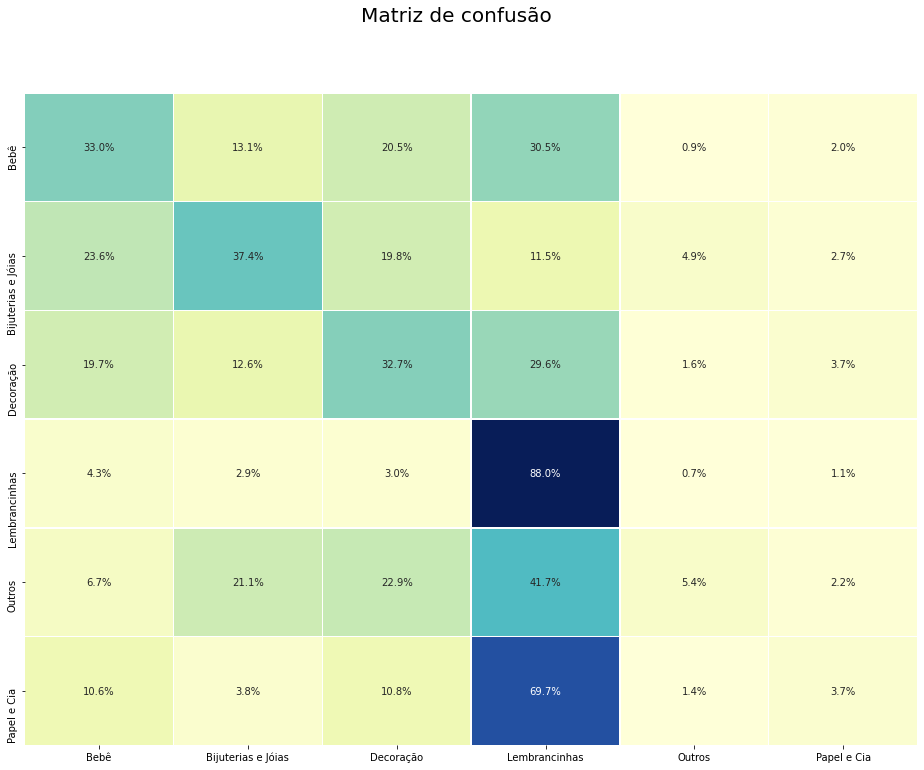

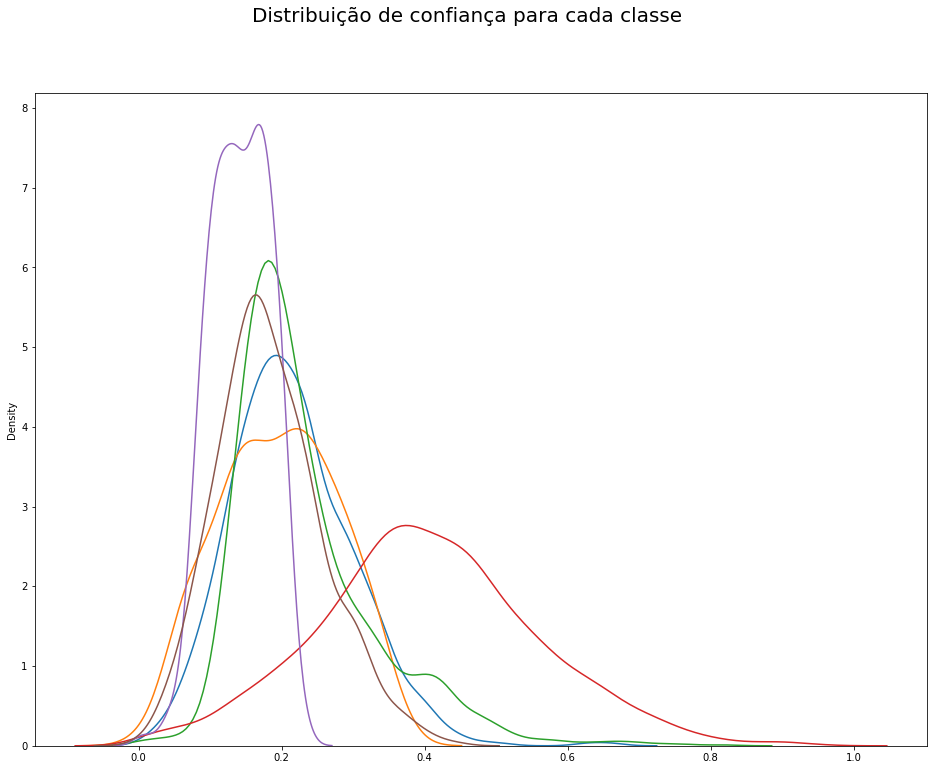

In [90]:
evaluate(y_test, clf_lr.predict(X_test[cols[2:]]), clf_lr.predict_proba(X_test[cols[2:]]), labels=le.classes_)

In [83]:
# Fazendo GridSearchCV

# parameters = {'criterion':('gini', 'entropy'),
#               'max_features':('auto', 'sqrt', 'log2'),
#               'max_depth':[2, 3, 5, 10],
#               'min_samples_split':[50, 75, 100],
#               'min_samples_leaf':[15, 25, 50, 75, 100]}
# RFC = RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1)
# 
# clf_RFC = GridSearchCV(RFC, parameters, scoring='balanced_accuracy', verbose=2)
# clf_RFC.fit(X_train[cols[2:]], y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samp

[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=75, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=auto, m

[CV]  criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=15, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt, min_sa

[CV]  criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=75, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=75, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=75, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=75, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=75, min_samples_split=75 
[CV]  criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=75, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt, min_samp

[CV]  criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=15, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=15, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=15, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=15, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=50 
[CV]  criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, m

[CV]  criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=75, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=75, min_samples_split=75 
[CV]  criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=75, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=75, min_samples_split=75 
[CV]  criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=75, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=75, min_samples_split=75 
[CV]  criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=75, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=75, min_samples_split=100 
[CV]  criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=75, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=2, max_features=log2, min_sa

[CV]  criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=50 
[CV]  criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=50 
[CV]  criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=50 
[CV]  criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=75 
[CV]  criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=auto, min_samp

[CV]  criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=75, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=75, min_samples_split=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=75, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=75, min_samples_split=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=75, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=75, min_samples_split=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=75, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=50, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=auto,

[CV]  criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=25, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=25, min_samples_split=75 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=25, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=25, min_samples_split=75 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=25, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=25, min_samples_split=75 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=25, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=sqrt, min_sa

[CV]  criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=50, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=75 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=75, total=   0.6s
[CV] criterion=gini, max_depth=3, max_features=sqrt,

[CV]  criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, m

[CV]  criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=75 
[CV]  criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=75 
[CV]  criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=75 
[CV]  criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=75, total=   0.4s
[CV] criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log

[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=75 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samp

[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=

[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=75 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, min_sa

[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samp

[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, m

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=au

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=75 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=auto

[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=10, max_feat

[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=75 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=75, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt

[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=15, min_samples_split=100, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=25, min_samples_split=50 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=25, min_samples_split=50, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=25, min_samples_split=50 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=25, min_samples_split=50, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=25, min_samples_split=50 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=25, min_samples_split=50, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=25, min_samples_split=50 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=25, min_samples_split=50, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=log

[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=75, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=100 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=100 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=100 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=100 
[CV]  criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=10, max_featu

[CV]  criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=25, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=25, min_samples_split=50 
[CV]  criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=25, min_samples_split=50, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=25, min_samples_split=75 
[CV]  criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=25, min_samples_split=75, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=25, min_samples_split=75 
[CV]  criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=25, min_samples_split=75, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=25, min_samples_split=75 
[CV]  criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=25, min_samples_split=75, total=   0.4s
[CV] criterion=entropy, max_depth=

[CV]  criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=75, min_samples_split=100, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=75, min_samples_split=100 
[CV]  criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=75, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=75, min_samples_split=100 
[CV]  criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=75, min_samples_split=100, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=100, min_samples_split=50, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=100, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, m

[CV]  criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=25, min_samples_split=75, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=25, min_samples_split=75 
[CV]  criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=25, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=25, min_samples_split=75 
[CV]  criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=25, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=25, min_samples_split=75 
[CV]  criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=25, min_samples_split=75, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_dept

[CV]  criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=100, min_samples_split=50, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=100, min_samples_split=50, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=100, min_samples_split=50, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=100, min_samples_split=50, total=   0.4s
[CV] criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=100, min_samples_split=50, total=   0.4s
[CV] criterion=entropy, m

[CV]  criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, ma

[CV]  criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=100, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=100, min_samples_split=50 
[CV]  criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=100, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=100, min_samples_split=75 
[CV]  criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=100, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=100, min_samples_split=75 
[CV]  criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=100, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=100, min_samples_split=75 
[CV]  criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=100, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, m

[CV]  criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=100 
[CV]  criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=25, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_d

[CV]  criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=75 
[CV]  criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=75 
[CV]  criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=75 
[CV]  criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] criterion=entropy,

[CV]  criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, total=   0.4s
[CV] criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, total=   0.4s
[CV] criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=

[CV]  criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=75, total=   0.4s
[CV] criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, total=   0.4s
[CV] criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, total=   0.4s
[CV] criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=100, min_samples_split=100, total=   0.4s
[CV] criterion=en

[CV]  criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=50 
[CV]  criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=75 
[CV]  criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=75 
[CV]  criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=75 
[CV]  criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=

[CV]  criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=100 
[CV]  criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, 

[CV]  criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=75 
[CV]  criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=75 
[CV]  criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=75 
[CV]  criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_dept

[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=

[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, ma

[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=50 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=50, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=75, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=15, min_samples_split=75, total=   0.6s
[CV] criterion=entropy, max_depth=

[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=50, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_d

[CV]  criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, total=   0.7s
[CV] criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, total=   0.7s
[CV] criterion=entropy,

[CV]  criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=50, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=75, min_samples_split=50, total=   0.6s
[CV] criterion=entropy, 

[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=100, total=   0.6s
[CV] criterion=entrop

[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=50, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=75, min_samples_split=50, total=   0.5s
[CV] criterion=entropy, m

[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=15, min_samples_split=75, total=   0.7s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=15, min_samples_split=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=15, min_samples_split=75, total=   0.7s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=15, min_samples_split=100, total=   0.7s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=15, min_samples_split=100, total=   0.7s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=15, min_samples_split=100 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=15, min_samples_split=100, total=   0.7s
[CV] criterion=entr

[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=50, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=50, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=50, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=50 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=50, total=   0.6s
[CV] criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=75 
[CV]  criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=75, min_samples_split=75, total=   0.6s
[CV] criterion=entropy, m

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 14.8min finished


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [2, 3, 5, 10],
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'min_samples_leaf': [15, 25, 50, 75, 100],
                         'min_samples_split': [50, 75, 100]},
             scoring='balanced_accuracy', verbose=2)

In [97]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(class_weight='balanced',
                       n_jobs=-1,
                       criterion = 'gini',
                       max_depth = 10,
                       max_features = 'log2',
                       min_samples_leaf = 15,
                       min_samples_split = 50)
clf_RFC = RFC.fit(X_train[cols[2:]], y_train)

In [100]:
import pickle
with open('trainer.pkl', 'wb') as model_file:
    pickle.dump(clf_RFC, model_file)

['.dockerignore',
 '.env',
 '.ipynb_checkpoints',
 'docker-compose.yml',
 'Dockerfile',
 'packages.txt',
 'README.md',
 'requirements.txt',
 'Train.ipynb',
 'trainer.pkl']

In [ ]:
# Cálculo das métricas de acerto.
os.environ["METRICS_PATH"] = 'Accuracy: ' + str(metrics.accuracy_score(y_test, clf_RFC.predict(X_test[cols[2:]])).round(3))

In [106]:
os.environ["MODEL_PATH"] = os.getcwd().replace('\\','/') + '/trainer.pkl'

Accuracy: 0.566
Accuracy (balanced): 0.48


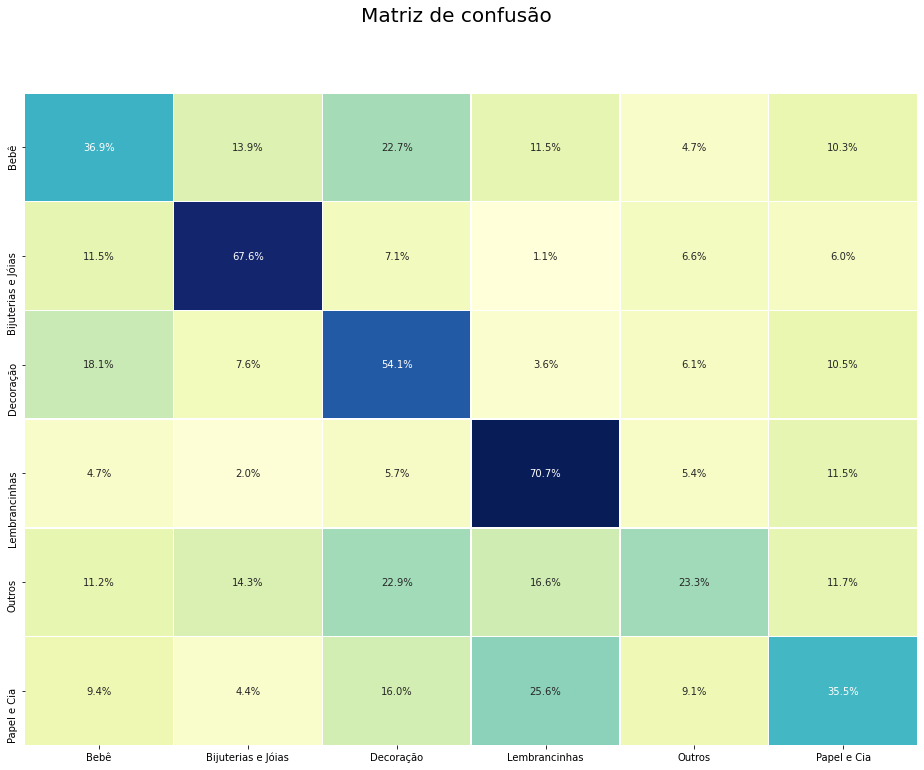

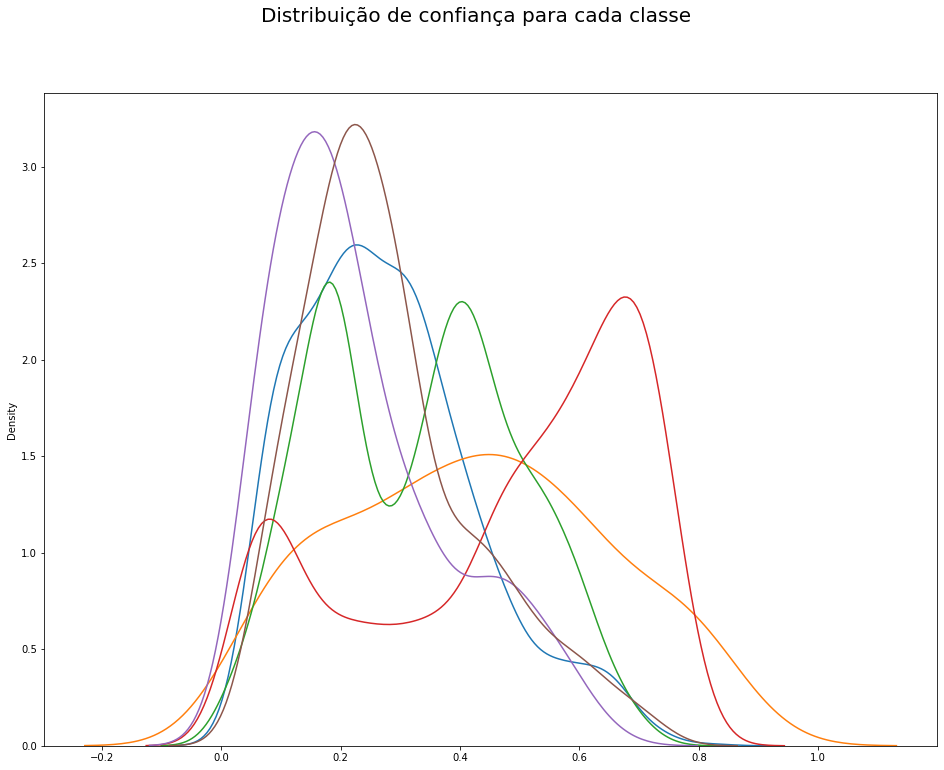

In [98]:
evaluate(y_test, clf_RFC.predict(X_test[cols[2:]]), clf_RFC.predict_proba(X_test[cols[2:]]), labels=le.classes_)

### Conclusão